<a href="https://colab.research.google.com/github/stevejj4/Insurance-data-lifecycle/blob/main/Machine_Learning_pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install google-cloud-bigquery
!pip install pyspark==3.1.2

from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
import pandas as pd



In [53]:
# Authenticating and initializing BigQuery client
project_id = 'river-messenger-430112-e1'
client = bigquery.Client(project=project_id)


In [54]:
# Combined query to join customers, policies, claims, and ML_team tables
query = """
SELECT
    c.CustomerID,
    c.Age,
    p.PolicyType,
    cl.ClaimAmount,
    cl.ClaimStatus,
    mt.DurationIndex,
    mt.PolicyTypeIndex,
    mt.PremiumAmount
FROM
    `river-messenger-430112-e1.Insurance_data.customers` c
JOIN
    `river-messenger-430112-e1.Insurance_data.policies` p ON c.CustomerID = p.CustomerID
JOIN
    `river-messenger-430112-e1.Insurance_data.claims` cl ON c.CustomerID = cl.CustomerID
JOIN
    `river-messenger-430112-e1.Insurance_data.ML_team` mt ON c.CustomerID = mt.CustomerID;
"""

# Execute the query and convert to a pandas DataFrame
df = client.query(query).to_dataframe()

# Display the first few rows
df.head()


,CustomerID,Age,PolicyType,ClaimAmount,ClaimStatus,DurationIndex,PolicyTypeIndex,PremiumAmount
0,3,53,Auto,10903.28,Pending,0,3,3644.16
1,9,43,Auto,8817.71,Rejected,1,3,4010.11
2,9,43,Auto,18213.56,Rejected,1,3,4010.11
3,9,43,Auto,1700.61,Rejected,1,3,4010.11
4,24,39,Auto,4513.44,Pending,0,3,3700.61


In [55]:
# drop PolicyType and CustomerID
df = df.drop(['PolicyType', 'CustomerID'], axis=1)

In [72]:
df.dtypes

,0
Age,float64
ClaimAmount,float64
ClaimStatus,int64
DurationIndex,Int64
PolicyTypeIndex,Int64
PremiumAmount,float64


## Machine learning
# Regression Modelling
This is a supervised machine learning where we predict the claim amount the customer will get based on some condition (predictor variables)

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [58]:
# Feature scale Age and PremiumAmount
scaler = StandardScaler()
df[['Age', 'PremiumAmount']] = scaler.fit_transform(df[['Age', 'PremiumAmount']])

In [59]:
# encode ClaimStatus
le = LabelEncoder()
df['ClaimStatus'] = le.fit_transform(df['ClaimStatus'])

In [65]:
df.head()

,Age,ClaimAmount,ClaimStatus,DurationIndex,PolicyTypeIndex,PremiumAmount
0,0.562841,10903.28,1,0,3,0.562925
1,-0.086641,8817.71,2,1,3,0.880452
2,-0.086641,18213.56,2,1,3,0.880452
3,-0.086641,1700.61,2,1,3,0.880452
4,-0.346434,4513.44,1,0,3,0.611906


In [61]:
target = df['ClaimAmount']
features = df.drop(['ClaimAmount'], axis = 1)

In [62]:
# split into train and test in ration of 70% split and 30% for test
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size =0.3,random_state = 38)
print("Features_train size = ", features_train.shape)
print("Features_test size = ", features_test.shape)
print("Target_train size = ", target_train.shape)
print("Target_test size = ", target_test.shape)

Features_train size =  (2100, 5)
Features_test size =  (900, 5)
Target_train size =  (2100,)
Target_test size =  (900,)


In [63]:
# Creating and training the model
model = LinearRegression()
model.fit(features_train, target_train)

LinearRegression()

In [64]:
# Evaluating the model RMSE
target_pred = model.predict(features_test)
mse = mean_squared_error(target_test, target_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 30491335.339901913


In [80]:
df.head()

,Age,ClaimAmount,ClaimStatus,DurationIndex,PolicyTypeIndex,PremiumAmount
0,0.562841,10903.28,1,0,3,0.562925
1,-0.086641,8817.71,2,1,3,0.880452
2,-0.086641,18213.56,2,1,3,0.880452
3,-0.086641,1700.61,2,1,3,0.880452
4,-0.346434,4513.44,1,0,3,0.611906


In [76]:
import numpy as np
# Assuming 'df' is your DataFrame with 'ClaimAmount' as the target
target = df['ClaimAmount']
features = df.drop(['ClaimAmount'], axis=1)

# Split into train and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=38
)

# Convert features and target to NumPy arrays for efficiency
features_train = features_train.values.astype(np.float64)
features_test = features_test.values.astype(np.float64)
target_train = target_train.values.astype(np.float64)
target_test = target_test.values.astype(np.float64)

# Add a bias (intercept) term to the features
features_train = np.c_[np.ones(features_train.shape[0]), features_train]
features_test = np.c_[np.ones(features_test.shape[0]), features_test]

# Initialize weights randomly
weights = np.random.randn(features_train.shape[1])

# Hyperparameters
learning_rate = 0.001  # Adjust as needed
n_iterations = 1000

# Gradient Descent
for i in range(n_iterations):
    predictions = np.dot(features_train, weights)
    errors = predictions - target_train
    gradients = 2 / len(features_train) * np.dot(features_train.T, errors)
    weights -= learning_rate * gradients

# The final weights after gradient descent
print("Weights after gradient descent:", weights)

# Predictions on test set
test_predictions = np.dot(features_test, weights)

# Evaluate the model using RMSE
mse = mean_squared_error(target_test, test_predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error on Test Set:", rmse)

Weights after gradient descent: [4608.2395741  -137.18428074 1938.45295491  553.33486131 1600.43915287
 -277.53144728]
Root Mean Squared Error on Test Set: 6190.002418430892


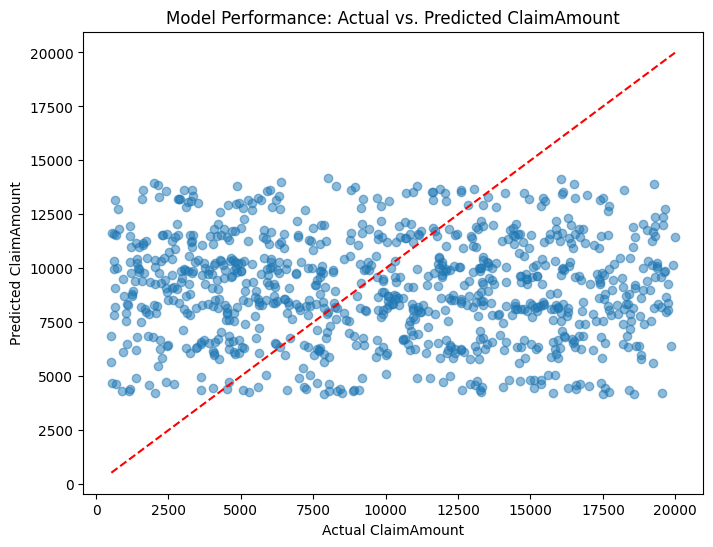

In [79]:
import matplotlib.pyplot as plt

# Assuming 'target_test' and 'test_predictions' are already calculated as in your previous code

plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.scatter(target_test, test_predictions, alpha=0.5)  # Scatter plot with some transparency
plt.xlabel("Actual ClaimAmount")
plt.ylabel("Predicted ClaimAmount")
plt.title("Model Performance: Actual vs. Predicted ClaimAmount")

# Add a diagonal line for perfect predictions
plt.plot([min(target_test), max(target_test)], [min(target_test), max(target_test)], color='red', linestyle='--')

plt.show()